In [5]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

# Path constants
DATA_DIR = 'data'
IMG_DIR = os.path.join(DATA_DIR, 'img_align_celeba')
ATTR_PATH = os.path.join(DATA_DIR, 'list_attr_celeba.csv')
PARTITION_PATH = os.path.join(DATA_DIR, 'list_eval_partition.csv')

Load Atrributes and Partitions

In [2]:
# Load attributes
df_attr = pd.read_csv(ATTR_PATH)
df_attr.rename(columns={'Unnamed: 0': 'image_id'}, inplace=True)

# Load partition info
df_partition = pd.read_csv(PARTITION_PATH)
df_partition.rename(columns={'Unnamed: 0': 'image_id'}, inplace=True)

# Merge attributes and partition
df = pd.merge(df_attr[['image_id', 'Eyeglasses']], df_partition, on='image_id')
df.head()

,image_id,Eyeglasses,partition
0,000001.jpg,-1,0
1,000002.jpg,-1,0
2,000003.jpg,-1,0
3,000004.jpg,-1,0
4,000005.jpg,-1,0


Converting labels to binary

In [3]:
# Converting -1 to 0 (no glasses), 1 stays as 1 (glasses)
df['Eyeglasses'] = df['Eyeglasses'].apply(lambda x: 1 if x == 1 else 0)

Adding full image path

In [4]:
df['img_path'] = df['image_id'].apply(lambda x: os.path.join(IMG_DIR, x))

Splitting the data into train/validate/test

In [5]:
# Splitting based on partition
df_train = df[df['partition'] == 0]
df_val = df[df['partition'] == 1]
df_test = df[df['partition'] == 2]

print(f"Training set size: {len(df_train)}")
print(f"Validation set size: {len(df_val)}")
print(f"Test set size: {len(df_test)}")


Training set size: 162770
Validation set size: 19867
Test set size: 19962


In [6]:
df_train.to_csv('train_metadata.csv', index=False)
df_val.to_csv('val_metadata.csv', index=False)
df_test.to_csv('test_metadata.csv', index=False)

Quick Check

In [7]:
print(df_train['Eyeglasses'].value_counts())
print(df_val['Eyeglasses'].value_counts())
print(df_test['Eyeglasses'].value_counts())

Eyeglasses
0    152249
1     10521
Name: count, dtype: int64
Eyeglasses
0    18484
1     1383
Name: count, dtype: int64
Eyeglasses
0    18673
1     1289
Name: count, dtype: int64


Observation :
We have a heavily imbalanced dataset — way more people without glasses than with glasses (~1:14 ratio).


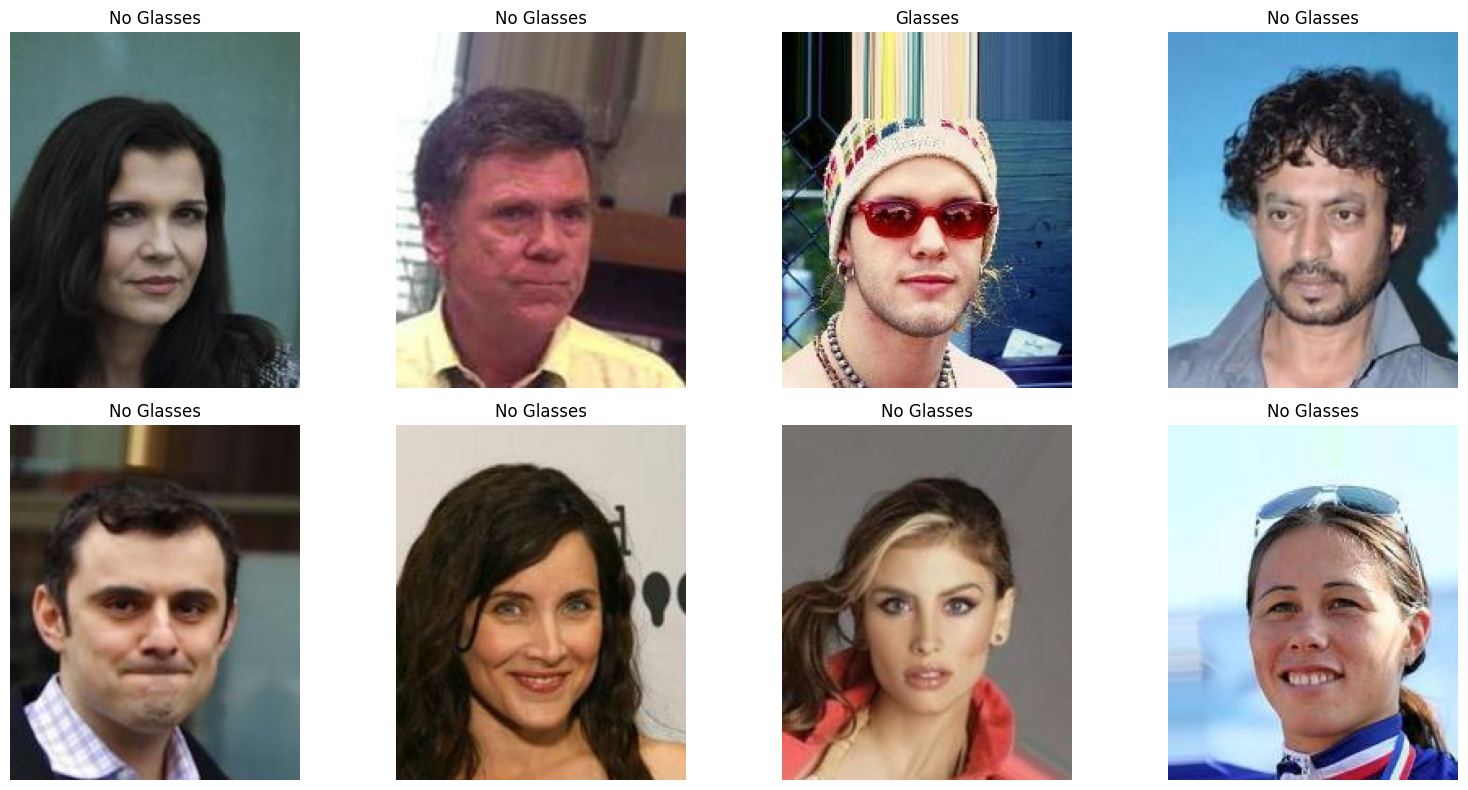

In [ ]:
import matplotlib.pyplot as plt
import random
from PIL import Image

# Load processed training dataframe
train_df = pd.read_csv('train_metadata.csv')

# Function to show random images
def visualize_random_samples(df, num_samples=8):
    samples = df.sample(num_samples)
    
    plt.figure(figsize=(16, 8))
    for idx, row in enumerate(samples.itertuples(), 1):
        img = Image.open(row.img_path)

        plt.subplot(2, num_samples//2, idx)
        plt.imshow(img)
        label = 'Glasses' if row.Eyeglasses == 1 else 'No Glasses'
        plt.title(label)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize
visualize_random_samples(train_df)


#### Input Pipeline

In [1]:
import tensorflow as tf

# Constants
IMG_SIZE = 128  # Resize all images to 128x128
BATCH_SIZE = 32  # Number of images per batch
AUTOTUNE = tf.data.experimental.AUTOTUNE  # For performance optimization

In [ ]:
# Function to load and preprocess a single image
def load_and_preprocess_image(path, label):
    # Read the image
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    
    # Resize the image
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    
    # Normalize to [0, 1]
    image = image / 255.0
    
    return image, label

In [ ]:
# Function to create tf.data.Dataset
def create_dataset(csv_path, shuffle=True):
    # Load CSV
    df = pd.read_csv(csv_path)
    
    # Get image paths and labels
    img_paths = df['img_path'].values
    labels = df['Eyeglasses'].values
    
    # Create a tf.data.Dataset
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, labels))
    
    # Map the preprocessing functio
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000)
    
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [6]:
train_ds = create_dataset('train_metadata.csv', shuffle=True)
val_ds = create_dataset('val_metadata.csv', shuffle=False)
test_ds = create_dataset('test_metadata.csv', shuffle=False)

In [7]:
for images, labels in train_ds.take(1):
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")

Image batch shape: (32, 128, 128, 3)
Label batch shape: (32,)


2025-04-26 13:59:57.863289: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
